### IMPORTS

In [25]:
import numpy as np
from Meshing.Meshing import *
from Fields.Fields import *
from Kernels.Kernels import *
from Solvers.Solvers import *
from Subchannel.FluidRelation import FluidRelation
from Subchannel.Channel import Channel
from Subchannel.Channel import ChannelInterface



### ST.ST. THERMAL HYDRAULICS

In [26]:
_dt = 1e321

gravity = 9.81
Dh = 0.0158276279311347000000
perim = 0.07267978843558340
area = 0.000287587162368000000
temp_tolerance = 1e-10
max_temp_iterations = 1000
nZones=50
L0 = 0.0
L1 = 1.74
fluid = FluidRelation(cp=1983, mu=0.00744, k=1.44, rho_0 = 2715.13, drho_dT=-0.513)
pressure_bc = 0.0
T_bc = 900.0
mdot_bc = 0.12292778 # Set to have a 9.1725 second residence time in the main core.
fric = 'type1'
heat_source = [0.0]*nZones # heat source in W/m3

#################
# CHANNEL SETUPS
#################
ch = Channel(gravity=gravity,
             Dh=Dh,
             area=area,
             temp_tolerance=temp_tolerance,
             max_temp_iterations=max_temp_iterations,
             nZones=nZones,
             L0=L0,
             L1=L1,
             fluid=fluid,
             pressure_bc=pressure_bc,
             T_bc=T_bc,
             mdot_bc=mdot_bc,
             fric=fric,
             heat_source=heat_source)

upper_plenum = Channel(gravity=gravity,
                       Dh=Dh,
                       area=1.5424651E-04,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0.0,
                       L1=1.0,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)

external_loop = Channel(gravity=gravity,
                       Dh=Dh,
                       area=1.0005305523E-03,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0.0,
                       L1=1.0,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)

lower_plenum = Channel(gravity=gravity,
                       Dh=Dh,
                       area=2.20816E-04,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0.0,
                       L1=1.0,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)

# Interfaces to handle data passing from one channel to another.
ch_to_up = ChannelInterface(ch1=ch, ch2=upper_plenum)
up_to_ex = ChannelInterface(ch1=upper_plenum, ch2=external_loop)
ex_to_lp = ChannelInterface(ch1=external_loop, ch2=lower_plenum)
lp_to_ch = ChannelInterface(ch1=lower_plenum, ch2=ch)

# Solution order - main channel -> plenum -> external loop -> lower plenum -> main channel
ch.solve_channel_TH(_dt=_dt)
ch_to_up.update_interface_conditions(tracer_bool=False, th_bool=True)

upper_plenum.solve_channel_TH(_dt=_dt)
up_to_ex.update_interface_conditions(tracer_bool=False, th_bool=True)

external_loop.solve_channel_TH(_dt=_dt)
ex_to_lp.update_interface_conditions(tracer_bool=False, th_bool=True)

lower_plenum.solve_channel_TH(_dt=_dt)
lp_to_ch.update_interface_conditions(tracer_bool=False, th_bool=True)

# End
print(ch.get_channel_residence_time())
print(upper_plenum.get_channel_residence_time())
print(external_loop.get_channel_residence_time())
print(lower_plenum.get_channel_residence_time())


Channel solved after 1 iterations!
Channel solved after 2 iterations!
Channel solved after 2 iterations!
Channel solved after 2 iterations!
9.173029223932662
2.8275440508996414
18.341058160078955
4.0478515017516825


### STEADY STATE TRACERS

In [27]:
tracer_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']
initial_value_tracers = 0.0
scheme_tracers = 'upwind'
decay_consts = [0.05, 0.10, 0.15, 0.20, 0.25, 1]
beta = [1.0,1.0,1.0,1.0,1.0,1.0]
boundary = 'lower' # must be lower anyways
phi_tracer = 1.0
rho_tracer = 1.0
src_function = np.sin(np.pi * np.array(ch.mesh.centroids) / L1)
fsrc = ScalarField(name='fsrc', initial_value=src_function, mesh=ch.mesh)



# TRACER SETUP IN MAIN CHANNEL
for idx, name in enumerate(tracer_names):
  ch.add_tracer_to_channel(name=tracer_names[idx], initial_value=initial_value_tracers,
                          scheme=scheme_tracers, decay_const=decay_consts[idx],
                          boundary=boundary, phi=phi_tracer, rho=rho_tracer, source=fsrc, beta=beta[idx])

# TRACER SETUP IN UPPER PLENUM
for idx, name in enumerate(tracer_names):
  upper_plenum.add_tracer_to_channel(name=tracer_names[idx], initial_value=0.0,
                                     scheme=scheme_tracers, decay_const=decay_consts[idx],
                                     boundary=boundary, phi=phi_tracer,rho=rho_tracer,source=0.0, beta=beta[idx])

# TRACER SETUP IN EXTERNAL LOOP
for idx, name in enumerate(tracer_names):
  external_loop.add_tracer_to_channel(name=tracer_names[idx], initial_value=0.0,
                                     scheme=scheme_tracers, decay_const=decay_consts[idx],
                                     boundary=boundary, phi=phi_tracer,rho=rho_tracer,source=0.0, beta=beta[idx])

# TRACER SETUP IN LOWER PLENUM
for idx, name in enumerate(tracer_names):
  lower_plenum.add_tracer_to_channel(name=tracer_names[idx], initial_value=0.0,
                                     scheme=scheme_tracers, decay_const=decay_consts[idx],
                                     boundary=boundary, phi=phi_tracer,rho=rho_tracer,source=0.0, beta=beta[idx])

# TRACER SOLVE LOOP
ch_inlet_value = phi_tracer
while True:
  ch.solve_all_tracers(_dt=_dt)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum.solve_all_tracers(_dt=_dt)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  external_loop.solve_all_tracers(_dt=_dt)
  ex_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum.solve_all_tracers(_dt=_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=True,th_bool=False)

  diff = np.abs(ch_inlet_value - ch.tracers['c1'].T[0])
  print(diff)
  ch_inlet_value = ch.tracers['c1'].T[0]
  if diff < 1e-12:
    break




0.0033793937271229257
0.5063051301702497
0.09171378072487557
0.016613336649425436
0.00300939458002758
0.0005451316571407627
9.874694584421917e-05
1.7887347367073758e-05
3.2401730833964137e-06
5.869356347609767e-07
1.0631945746020222e-07
1.925905679378559e-08
3.488646038718457e-09
6.319456069547869e-10
1.1447354175686542e-10
2.07360795201339e-11
3.7554404030970545e-12
6.787903572558207e-13


### TURN OFF SOURCE AND RUN TRANSIENT

In [28]:


# setup timestep vector
timesteps = np.linspace(-5, 200, 1000)

# Update old values in channel before starting simulation
ch.update_old_to_most_recent()
upper_plenum.update_old_to_most_recent()
external_loop.update_old_to_most_recent()
lower_plenum.update_old_to_most_recent()

# Transient solver
t_prev = 0.0
for t_new in timesteps:
  # turn off source function for tracers
  if t_new > 0:
    fsrc.T = fsrc.T*0.0

  this_dt = t_new - t_prev
  # print("NOW SOLVING AT TIME =", t_new, "| this_dt =", this_dt)


  ch.solve_all_tracers(_dt=this_dt)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum.solve_all_tracers(_dt=this_dt)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  external_loop.solve_all_tracers(_dt=this_dt)
  ex_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum.solve_all_tracers(_dt=this_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=True,th_bool=False)

  ch.save_data(_t=t_new)
  upper_plenum.save_data(_t=t_new)
  external_loop.save_data(_t=t_new)
  lower_plenum.save_data(_t=t_new)

  ch.update_old_to_most_recent()
  upper_plenum.update_old_to_most_recent()
  external_loop.update_old_to_most_recent()
  lower_plenum.update_old_to_most_recent()

  t_prev = t_new


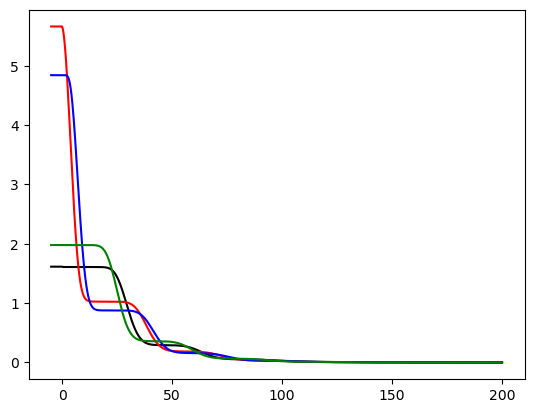

In [29]:
t,val = ch.get_tracer_vs_time(name='c1', pos=0)
plt.plot(t,val,'k-')
t,val = upper_plenum.get_tracer_vs_time(name='c1', pos=0)
plt.plot(t,val,'r-')
t,val = external_loop.get_tracer_vs_time(name='c1', pos=0)
plt.plot(t,val,'b-')
t,val = lower_plenum.get_tracer_vs_time(name='c1', pos=0)
plt.plot(t,val,'g-')

In [30]:
ch.tracers['c1'].T

array([0.00018941, 0.0001896 , 0.00018976, 0.0001899 , 0.00019003,
       0.00019013, 0.00019021, 0.00019028, 0.00019032, 0.00019034,
       0.00019034, 0.00019031, 0.00019027, 0.00019021, 0.00019012,
       0.00019002, 0.00018989, 0.00018975, 0.00018958, 0.0001894 ,
       0.00018919, 0.00018896, 0.00018872, 0.00018846, 0.00018817,
       0.00018787, 0.00018755, 0.00018721, 0.00018686, 0.00018649,
       0.0001861 , 0.0001857 , 0.00018527, 0.00018484, 0.00018439,
       0.00018392, 0.00018345, 0.00018295, 0.00018245, 0.00018193,
       0.0001814 , 0.00018086, 0.00018031, 0.00017975, 0.00017918,
       0.0001786 , 0.00017802, 0.00017742, 0.00017682, 0.00017621])

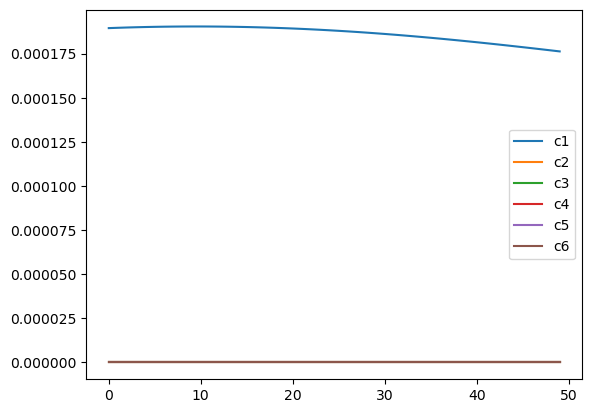

In [31]:
for this in ch.tracers.keys():
  plt.plot(ch.tracers[this].T, label=this)
plt.legend()

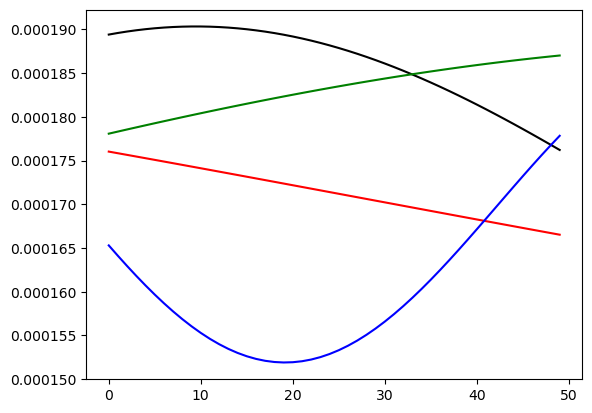

In [32]:
tracer_name = 'c1'
plt.plot(ch.tracers[tracer_name].T, 'k')
plt.plot(upper_plenum.tracers[tracer_name].T, 'r')
plt.plot(external_loop.tracers[tracer_name].T, 'b')
plt.plot(lower_plenum.tracers[tracer_name].T, 'g')